In [6]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import re
from bs4 import BeautifulSoup
import string
from textblob import TextBlob
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


In [50]:
# Load the dataset
complaints_df = pd.read_excel('/content/drive/MyDrive/dataset/Copy of Team 3 - Complaints.xlsx')

In [51]:


# Preprocess the narratives
def preprocess_narrative(narrative):
    if pd.isna(narrative):
        return ''  # Return an empty string for NaN values

    # Remove HTML tags
    narrative = BeautifulSoup(narrative, 'html.parser').get_text()

    # Remove URLs
    narrative = re.sub(r'http\S+', '', narrative)

    # Convert to lowercase
    narrative = narrative.lower()

    # Remove punctuation
    narrative = narrative.translate(str.maketrans('', '', string.punctuation))

    # Tokenize the narrative
    tokens = word_tokenize(narrative)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Correct spelling using TextBlob
    #corrected_tokens = [TextBlob(token).correct().string for token in tokens]

    # Remove extra whitespaces
    processed_narrative = ' '.join(tokens).strip()

    return processed_narrative


In [52]:
complaints_df['processed_narrative'] = complaints_df['narrative'].apply(preprocess_narrative)

In [45]:
complaints_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162421 entries, 0 to 162420
Data columns (total 4 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Unnamed: 0           162421 non-null  int64 
 1   product              162421 non-null  object
 2   narrative            162411 non-null  object
 3   processed_narrative  162421 non-null  object
dtypes: int64(1), object(3)
memory usage: 5.0+ MB


In [22]:
complaints_df.head()

Unnamed: 0           product  \
0           0       credit_card   
1           1       credit_card   
2           2    retail_banking   
3           3  credit_reporting   
4           4  credit_reporting   

                                           narrative  \
0  purchase order day shipping amount receive pro...   
1  forwarded message date tue subject please inve...   
2  forwarded message cc sent friday pdt subject f...   
3  payment history missing credit report speciali...   
4  payment history missing credit report made mis...   

                                 processed_narrative  
0  purchase order day shipping amount receive pro...  
1  forwarded message date tue subject please inve...  
2  forwarded message cc sent friday pdt subject f...  
3  payment history missing credit report speciali...  
4  payment history missing credit report made mis...

In [23]:
complaints_df['product'].value_counts()

product
credit_reporting       91179
debt_collection        23150
mortgages_and_loans    18990
credit_card            15566
retail_banking         13536
Name: count, dtype: int64

In [24]:
complaints_df.shape

(162421, 4)

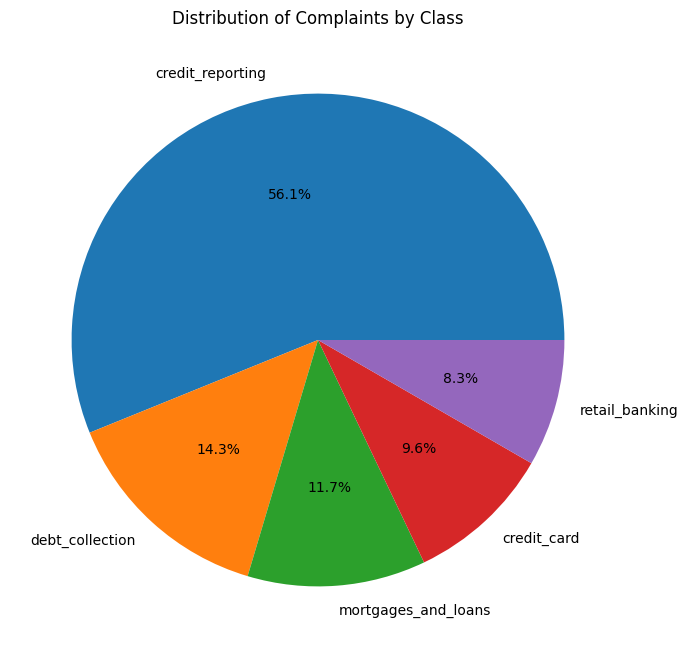

In [25]:
import matplotlib.pyplot as plt

# 1. Pie Chart for Class Distribution
class_counts = complaints_df['product'].value_counts().sort_values(ascending=False)  # Sort by descending order for better visibility in pie chart
plt.figure(figsize=(8, 8))  # Adjust figure size as needed
plt.pie(class_counts, labels=class_counts.index.to_numpy(), autopct="%1.1f%%")  # Display percentage labels
plt.title("Distribution of Complaints by Class")
plt.show()

In [53]:
# Split data into features (processed narratives) and target labels
X = complaints_df['processed_narrative']
y = complaints_df['product']


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()


# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)


# Transform the test data
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [58]:
# Initialize and train Logistic Regression model with tf idf
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)


# Predict and evaluate
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)


# Print results
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(report)


# Prediction model
def predict_class(text):
    # Preprocess the input text
    clean_text = preprocess_narrative(text)
    # Transform the preprocessed text using TF-IDF vectorizer
    text_tfidf = tfidf_vectorizer.transform([clean_text])
    # Predict the class
    predicted_class = model.predict(text_tfidf)[0]
    return predicted_class



Accuracy: 0.8705
Classification Report:
                     precision    recall  f1-score   support

        credit_card       0.80      0.79      0.79      3212
   credit_reporting       0.90      0.93      0.92     18130
    debt_collection       0.80      0.72      0.76      4619
mortgages_and_loans       0.85      0.82      0.84      3738
     retail_banking       0.87      0.87      0.87      2786

           accuracy                           0.87     32485
          macro avg       0.84      0.83      0.83     32485
       weighted avg       0.87      0.87      0.87     32485



In [54]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [55]:
from tqdm import tqdm
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re


complaints_df['full_text'] = complaints_df['narrative'].fillna('')

def generate_sentiment_scores(df: pd.DataFrame):
    def overall_sentiment(negative, positive):
        if (sentence_sentiment_score['compound'] >= -1 ) and (sentence_sentiment_score['compound'] < -0.5) :
          return"Aggression"
        elif (sentence_sentiment_score['compound'] >= -0.5 ) and (sentence_sentiment_score['compound'] < 0) :
          return"Frustration"
        elif (sentence_sentiment_score['compound'] >= 0 ) and (sentence_sentiment_score['compound'] < 0.5) :
          return"disappointed"
        else :
          return"neutral"


    sid = SentimentIntensityAnalyzer()
    neg, pos, overall = [], [], []
    for sentence in tqdm(df['full_text'].values):
        sentence_sentiment_score = sid.polarity_scores(sentence)
        neg.append(sentence_sentiment_score['neg'])
        pos.append(sentence_sentiment_score['pos'])
        overall.append(overall_sentiment(sentence_sentiment_score['neg'], sentence_sentiment_score['pos']))
    return neg, pos, overall

In [56]:
complaints_df['negative'], complaints_df['positive'], complaints_df['overall_sentiment']= generate_sentiment_scores(complaints_df)

print(complaints_df.iloc[0])
print(complaints_df.iloc[3])

100%|██████████| 162421/162421 [03:04<00:00, 880.31it/s]


Unnamed: 0                                                             0
product                                                      credit_card
narrative              purchase order day shipping amount receive pro...
processed_narrative    purchase order day shipping amount receive pro...
full_text              purchase order day shipping amount receive pro...
negative                                                           0.078
positive                                                            0.08
overall_sentiment                                           disappointed
Name: 0, dtype: object
Unnamed: 0                                                             3
product                                                 credit_reporting
narrative              payment history missing credit report speciali...
processed_narrative    payment history missing credit report speciali...
full_text              payment history missing credit report speciali...
negative                    

In [61]:


# Example usage of the prediction model
user_input = input("Enter your complaint: ")
predicted_class = predict_class(user_input)
print("Predicted class:", predicted_class)

Enter your complaint: TypeError                                 Traceback (most recent call last) <ipython-input-60-55fef13e7c78> in <cell line: 5>()       3 predicted_class = predict_class(user_input)       4 print("Predicted class:", predicted_class) ----> 5 print(generate_sentiment_scores(user_input))  <ipython-input-55-261a046a966d> in generate_sentiment_scores(df)      20     sid = SentimentIntensityAnalyzer()      21     neg, pos, overall = [], [], [] ---> 22     for sentence in tqdm(df['full_text'].values):      23         sentence_sentiment_score = sid.polarity_scores(sentence)      24         neg.append(sentence_sentiment_score['neg'])  TypeError: string indices must be integers
Predicted class: debt_collection
